In [48]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from utils import *
warnings.filterwarnings('ignore')

LOADING DATA


In [49]:
accel_data = pd.read_csv("data/all_accelerometer_data_pids_13.csv")
phone_data = pd.read_csv("data/phone_types.csv")


In [50]:
extracted_files = []
for root, dirs, files in os.walk('data'):
    for file in files:
        extracted_files.append(os.path.join(root, file))

In [51]:
extracted_data = {
    os.path.basename(file).split("_")[0]: pd.read_csv(file)
    for file in extracted_files if "clean_tac" in file and file.endswith(".csv")
}

print("Extracted PIDs:", list(extracted_data.keys()))

Extracted PIDs: ['DK3500', 'JR8022', 'SA0297', 'BU4707', 'HV0618', 'SF3079', 'MJ8002', 'CC6740', 'PC6771', 'MC7070', 'DC6359', 'BK7610', 'JB3156']


In [52]:
tac_files = [f for f in extracted_files if "clean_tac" in f and f.endswith(".csv")]
tac_data_list = [pd.read_csv(f) for f in tac_files]

In [53]:
for df, file_path in zip(tac_data_list, tac_files):
    pid = os.path.basename(file_path).split("_")[0]  # Extract PID from filename
    df["pid"] = pid

In [54]:
m2s = lambda x: x // 1000

accel_data['timestamp'] = accel_data['time'].apply(m2s)

In [ ]:
for axis in ['x', 'y', 'z']:
    accel_data[axis] = accel_data[axis] / 40

In [56]:
unique_pids = np.unique(phone_data['pid'])
filtered_dfs = {pid: accel_data[accel_data['pid'] == pid] for pid in unique_pids}

In [57]:
filter_by_id = lambda data, id: data[data['pid'] == id]

In [58]:
dfs = {os.path.basename(file_name): pd.read_csv(file_name) for file_name in extracted_files if "clean_tac" in file_name and file_name.endswith(".csv")}

In [59]:
print(f"Unique PIDs: {unique_pids.tolist()}")

Unique PIDs: ['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618', 'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297', 'SF3079']


In [60]:
unique_pids

array(['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618',
       'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297',
       'SF3079'], dtype=object)

In [61]:
dfs.keys()

dict_keys(['DK3500_clean_TAC.csv', 'JR8022_clean_TAC.csv', 'SA0297_clean_TAC.csv', 'BU4707_clean_TAC.csv', 'HV0618_clean_TAC.csv', 'SF3079_clean_TAC.csv', 'MJ8002_clean_TAC.csv', 'CC6740_clean_TAC.csv', 'PC6771_clean_TAC.csv', 'MC7070_clean_TAC.csv', 'DC6359_clean_TAC.csv', 'BK7610_clean_TAC.csv', 'JB3156_clean_TAC.csv'])

In [62]:
filtered_dfs = {pid: accel_data[accel_data['pid'] == pid] for pid in unique_pids}

merged_dfs = {
    pid: pd.merge(filtered_dfs[pid], extracted_data[pid], on="timestamp", how="inner")
    for pid in unique_pids
}


In [63]:
filtered_dfs

{'BK7610':                   time     pid         x         y         z   timestamp
 47136    1493735870653  BK7610  0.003152 -0.000195 -0.000607  1493735870
 47138    1493735870679  BK7610  0.003340 -0.001742 -0.001115  1493735870
 47140    1493735870703  BK7610  0.003608 -0.001185 -0.001118  1493735870
 47142    1493735870729  BK7610  0.003138 -0.000095  0.000278  1493735870
 47144    1493735870753  BK7610  0.002690  0.000080  0.000690  1493735870
 ...                ...     ...       ...       ...       ...         ...
 6071104  1493767770540  BK7610 -0.001960 -0.000402  0.004298  1493767770
 6071108  1493767770564  BK7610 -0.000988 -0.002040  0.004085  1493767770
 6071112  1493767770590  BK7610  0.000400 -0.002132  0.002265  1493767770
 6071117  1493767770614  BK7610  0.002253 -0.001918  0.000405  1493767770
 6071121  1493767770640  BK7610  0.004250 -0.003475 -0.001932  1493767770
 
 [1225727 rows x 6 columns],
 'BU4707':                   time     pid         x         y         z

In [64]:
merged_df = {pid: df.sort_values(by=['TAC_Reading']).reset_index(drop=True) for pid, df in merged_dfs.items()}

In [65]:
def generate_tac_segments(sorted_tac_series):
    value_counts = sorted_tac_series.value_counts().sort_index(ascending=True)
    return pd.Series(value_counts.tolist(), index=value_counts.index, name='count')

In [66]:
tac_segments = {pid: generate_tac_segments(df['TAC_Reading']) for pid, df in merged_df.items()}

In [67]:
tac_data = pd.concat(tac_data_list, ignore_index=True)

accel_data["time"] = pd.to_datetime(accel_data["time"], unit="ms")
tac_data["timestamp"] = pd.to_datetime(tac_data["timestamp"], unit="s")

accel_data = accel_data.merge(phone_data, on="pid", how="left")
accel_data = accel_data.drop(columns=['timestamp'])



In [68]:
accel_data.head()

,time,pid,x,y,z,phonetype
0,1970-01-01 00:00:00.000,JB3156,0.000000,0.000000,0.000000,Android
1,1970-01-01 00:00:00.000,CC6740,0.000000,0.000000,0.000000,Android
2,2017-05-02 14:04:42.409,SA0297,0.001895,0.000683,-0.000255,iPhone
3,2017-05-02 14:04:42.455,SA0297,-0.000898,0.001985,0.000092,iPhone
4,2017-05-02 14:04:42.500,SA0297,-0.006067,-0.002152,-0.000407,iPhone


In [69]:
tac_data.head()

,timestamp,TAC_Reading,pid
0,2017-05-02 12:23:40,0.000215,DK3500
1,2017-05-02 12:26:59,0.001716,DK3500
2,2017-05-02 12:57:21,0.001921,DK3500
3,2017-05-02 13:27:47,0.000569,DK3500
4,2017-05-02 13:33:14,-0.001321,DK3500


In [70]:
save_path  = '/Users/mane/Desktop/Capstone-Project/data/merged_data'

In [71]:
os.makedirs(save_path, exist_ok=True)
accel_data.to_csv(os.path.join(save_path, "accelerometer_data.csv"), index=False)
tac_data.to_csv(os.path.join(save_path, "tac_data.csv"), index=False)

In [72]:
len(accel_data), len(tac_data)

(14057567, 715)

In [73]:
accel_data["time"] = pd.to_datetime(accel_data["time"])
tac_data["timestamp"] = pd.to_datetime(tac_data["timestamp"])

In [74]:
save_processed_path = '/Users/mane/Desktop/Capstone-Project/data/processed_merged_data'
os.makedirs(save_processed_path, exist_ok=True)
accel_data.to_csv(os.path.join(save_processed_path, "accelerometer_data_processed.csv"), index=False)
tac_data.to_csv(os.path.join(save_processed_path, "tac_data_processed.csv"), index=False)

In [75]:
output_dir = 'data/processed_data'
os.makedirs(output_dir, exist_ok=True)

for pid, axes_data in results.items():
    output_path = os.path.join(output_dir, f"{pid}_processed.csv")
    combined_df = pd.concat(axes_data.values(), keys=axes_data.keys(), names=['Axis'])
    combined_df.to_csv(output_path)

In [76]:
tac_reading_counts = {
    pid: pd.Series(df['TAC_Reading'].value_counts().sort_values(ascending=False).tolist(), name='count')
    for pid, df in merged_dfs.items()
}

In [77]:
tac_reading_counts['BK7610']

0     40
1     40
2     40
3     40
4     40
5     40
6     40
7     40
8     40
9     40
10    40
11    40
12    40
13    39
14    39
15    38
16    38
Name: count, dtype: int64

In [78]:
results = {}

for pid, df in merged_dfs.items():
    sorted_df = df.sort_values(by=['TAC_Reading']).reset_index(drop=True)
    tac_counts = tac_reading_counts[pid]

    pe_results = {'x': [], 'y': [], 'z': []}
    comp_results = {'x': [], 'y': [], 'z': []}
    tac_readings = []

    start_index = 0
    unique_tac_values = sorted_df['TAC_Reading'].unique()
    
    for segment_index, segment_value in enumerate(tac_counts):
        end_index = start_index + segment_value
        if end_index > len(sorted_df):  
            end_index = len(sorted_df)

        if segment_index < len(unique_tac_values):  
            tac_readings.append(unique_tac_values[segment_index])
        else:
            tac_readings.append(np.nan)

        for axis in ['x', 'y', 'z']:
            segment = sorted_df[axis].iloc[start_index:end_index].dropna()

            if len(segment) < 3:
                pe_results[axis].append(np.nan)
                comp_results[axis].append(np.nan)
            else:
                op = ordinal_patterns(segment.values, 3, 1)
                pe_results[axis].append(p_entropy(op))
                comp_results[axis].append(complexity(op))

        start_index = end_index

    tac_readings = tac_readings[:len(pe_results['x'])]

    results[pid] = {
        axis: pd.DataFrame({
            'Pe_results': pe_results[axis], 
            'Comp_results': comp_results[axis], 
            'TAC_Reading': tac_readings
        }).sort_values(by=['TAC_Reading'], ascending=True).reset_index(drop=True)
        for axis in ['x', 'y', 'z']
    }


In [79]:
for pid in results.keys():
    for axis in ['x', 'y', 'z']:
        results[pid][axis]['Sober_classification'] = results[pid][axis]['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

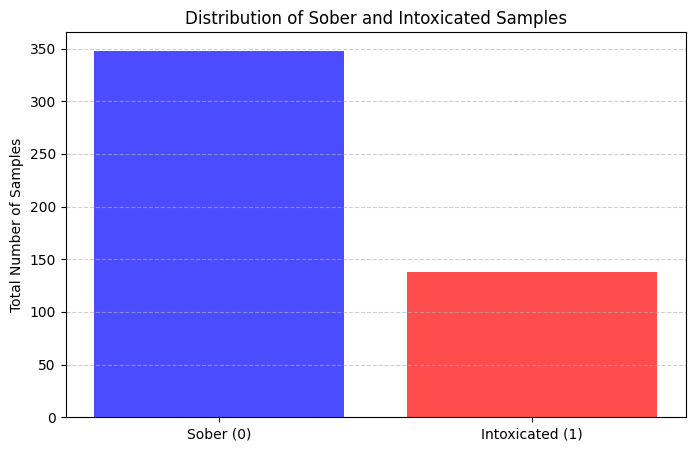

{0: 348, 1: 138}

In [80]:
sober_counts = {0: 0, 1: 0}

for pid in results.keys():
    for axis in ['x', 'y', 'z']:
        counts = results[pid][axis]['Sober_classification'].value_counts()
        sober_counts[0] += counts.get(0, 0)
        sober_counts[1] += counts.get(1, 0)

plt.figure(figsize=(8, 5))
plt.bar(sober_counts.keys(), sober_counts.values(), color=['blue', 'red'], alpha=0.7)
plt.xticks([0, 1], ['Sober (0)', 'Intoxicated (1)'])
plt.ylabel('Total Number of Samples')
plt.title('Distribution of Sober and Intoxicated Samples')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

sober_counts


In [81]:
results = {}

for pid, df in merged_dfs.items():
    sorted_df = df.sort_values(by=['TAC_Reading']).reset_index(drop=True)
    tac_counts = tac_reading_counts[pid]

    pe_results = {'x': [], 'y': [], 'z': []}
    comp_results = {'x': [], 'y': [], 'z': []}
    tac_readings = []

    start_index = 0
    unique_tac_values = sorted_df['TAC_Reading'].unique()
    
    for segment_index, segment_value in enumerate(tac_counts):
        end_index = start_index + segment_value
        if end_index > len(sorted_df):  
            end_index = len(sorted_df)

        if segment_index < len(unique_tac_values):  
            tac_readings.append(unique_tac_values[segment_index])
        else:
            tac_readings.append(np.nan)

        for axis in ['x', 'y', 'z']:
            segment = sorted_df[axis].iloc[start_index:end_index].dropna()

            if len(segment) < 3:
                pe_results[axis].append(np.nan)
                comp_results[axis].append(np.nan)
            else:
                op = ordinal_patterns(segment.values, 3, 1)
                pe_results[axis].append(p_entropy(op))
                comp_results[axis].append(complexity(op))

        start_index = end_index

    tac_readings = tac_readings[:len(pe_results['x'])]

    results[pid] = {
        axis: pd.DataFrame({
            'Pe_results': pe_results[axis], 
            'Comp_results': comp_results[axis], 
            'TAC_Reading': tac_readings
        }).sort_values(by=['TAC_Reading'], ascending=True).reset_index(drop=True)
        for axis in ['x', 'y', 'z']
    }


In [82]:
def plot_pid_results(pid):
    if pid not in results:
        print(f"Error: PID {pid} not found in results.")
        return

    pe_x = results[pid]['x']['Pe_results']
    pe_y = results[pid]['y']['Pe_results']
    pe_z = results[pid]['z']['Pe_results']
    
    comp_x = results[pid]['x']['Comp_results']
    comp_y = results[pid]['y']['Comp_results']
    comp_z = results[pid]['z']['Comp_results']

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    sns.lineplot(data=pe_x[:20], ax=axes[0, 0], color='r')
    sns.lineplot(data=pe_y[:20], ax=axes[0, 1], color='g')
    sns.lineplot(data=pe_z[:20], ax=axes[0, 2], color='b')

    sns.lineplot(data=comp_x[:20], ax=axes[1, 0], color='r')
    sns.lineplot(data=comp_y[:20], ax=axes[1, 1], color='g')
    sns.lineplot(data=comp_z[:20], ax=axes[1, 2], color='b')

    axes[0, 0].set_title(f'pe_results_x_{pid}')
    axes[0, 1].set_title(f'pe_results_y_{pid}')
    axes[0, 2].set_title(f'pe_results_z_{pid}')
    axes[1, 0].set_title(f'comp_results_x_{pid}')
    axes[1, 1].set_title(f'comp_results_y_{pid}')
    axes[1, 2].set_title(f'comp_results_z_{pid}')

    for ax in axes.flatten():
        ax.set_xlabel("Segment Index")
        ax.set_ylabel("Value")
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

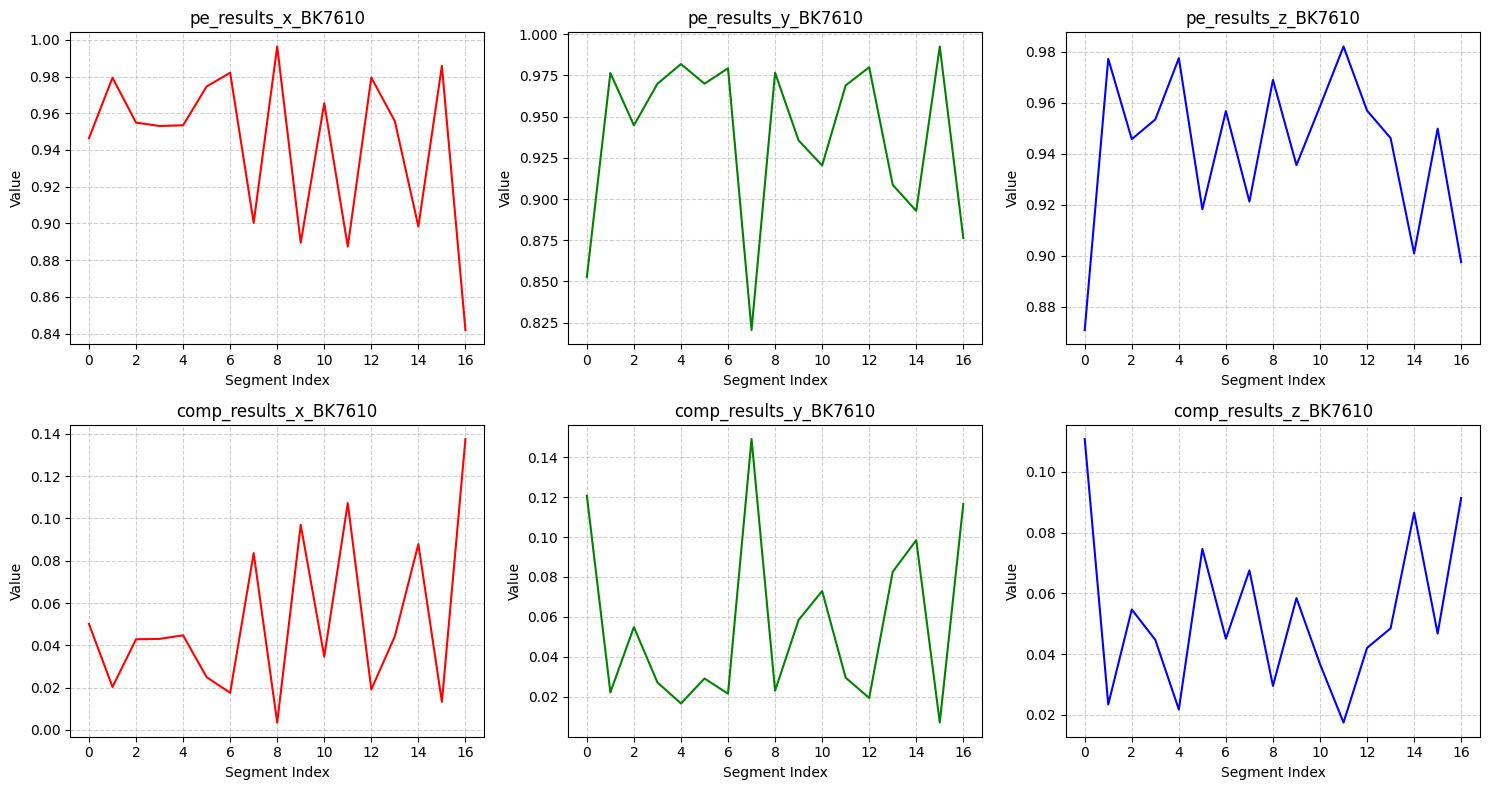

In [83]:
plot_pid_results("BK7610")

In [84]:
for pid in results.keys():
    for axis in ['x', 'y', 'z']:
        results[pid][axis]['Sober_classification'] = results[pid][axis]['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

In [85]:
def plot_results(pid):
    if pid not in results:
        print(f"Error: PID {pid} not found in results.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 1]})

    colors = {0: 'blue', 1: 'red'}

    def plot_scatter(ax, df, axis_label):
        for sober_class in df['Sober_classification'].unique():
            subset = df[df['Sober_classification'] == sober_class]
            ax.scatter(subset['Comp_results'], subset['Pe_results'], 
                       s=100,
                       color=colors[sober_class], 
                       label=f"Sober={sober_class}", alpha=0.7, edgecolors='black')

        ax.set_title(f'{pid} - {axis_label} Axis', fontsize=14, fontweight='bold')
        ax.set_xlabel('Complexity', fontsize=12)
        ax.set_ylabel('Permutation Entropy', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title="Sober Classification", fontsize=10)

    plot_scatter(axes[0, 0], results[pid]['x'], "X")
    plot_scatter(axes[0, 1], results[pid]['y'], "Y")

    fig.delaxes(axes[1, 1])
    plot_scatter(axes[1, 0], results[pid]['z'], "Z")

    plt.suptitle(f'Permutation Entropy vs Complexity - {pid}', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


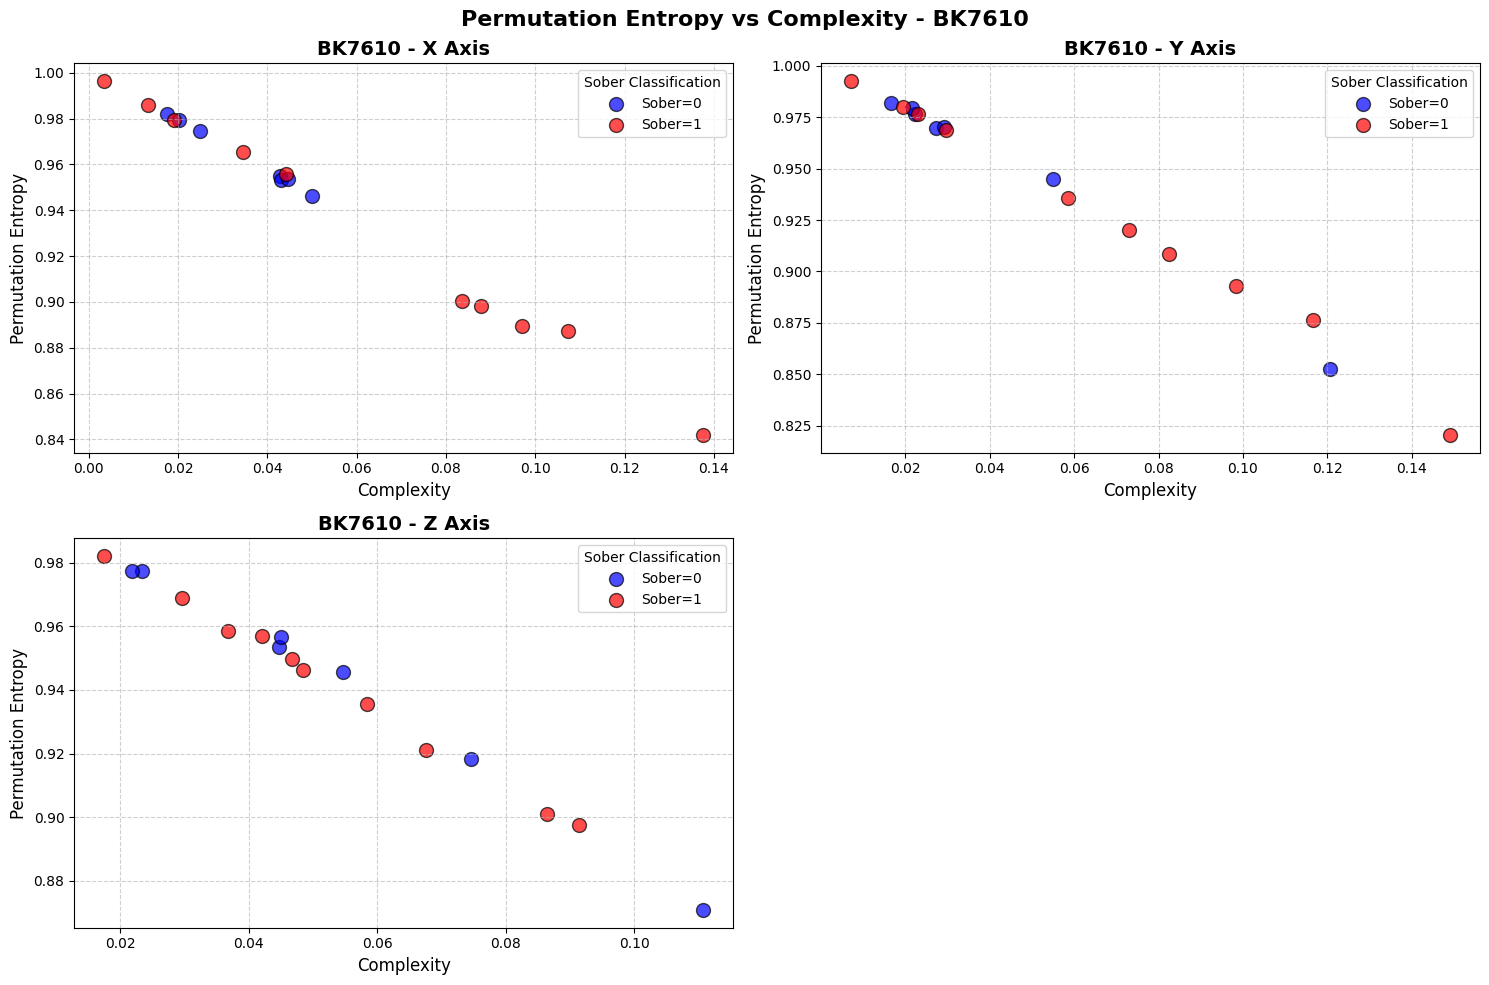

In [86]:
plot_results('BK7610')